# Advanced AI Models for Precision Medicine

## Overview
This notebook demonstrates advanced AI models that can be applied to the integrated genomic and clinical dataset.

### Models Covered:
1. **Deep Learning** - Neural Networks for complex patterns
2. **Ensemble Methods** - XGBoost, Random Forest
3. **Survival Analysis** - Time-to-event modeling
4. **Clustering** - Patient stratification
5. **Multi-modal Fusion** - Combining genomic + clinical data

**Prerequisites**: Run the real data integration notebook first to generate the merged dataset.

In [1]:
import sys
!{sys.executable} -m pip install xgboost lifelines seaborn scikit-learn

In [2]:
import sys
print("Python path:", sys.executable)

Python path: /Users/justin/energy-ai-azure/.venv/bin/python


In [3]:
# Advanced ML imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

# Try to import advanced libraries
try:
    import xgboost as xgb
    XGB_AVAILABLE = True
    print("XGBoost available")
except ImportError:
    XGB_AVAILABLE = False
    print("XGBoost not available. Install with: pip install xgboost")

try:
    from lifelines import CoxPHFitter, KaplanMeierFitter
    SURVIVAL_AVAILABLE = True
    print("Lifelines available")
except ImportError:
    SURVIVAL_AVAILABLE = False
    print("Lifelines not available. Install with: pip install lifelines")

print("Libraries imported successfully")

XGBoost available
Lifelines available
Libraries imported successfully


## Load Integrated Dataset

First, let's recreate the merged dataset from the previous notebook or load it if saved.

In [4]:
# Option 1: Recreate the dataset (same as previous notebook)
def create_sample_dataset():
    """Create the same sample dataset for demonstration"""
    # Genomic features
    genomic_features = pd.DataFrame({
        'patient_id': [f'TCGA-{i:04d}' for i in range(1, 21)],
        'TP53': np.random.choice([0, 1], 20, p=[0.6, 0.4]),
        'EGFR': np.random.choice([0, 1], 20, p=[0.7, 0.3]),
        'KRAS': np.random.choice([0, 1], 20, p=[0.8, 0.2]),
        'ALK': np.random.choice([0, 1], 20, p=[0.9, 0.1]),
        'PIK3CA': np.random.choice([0, 1], 20, p=[0.85, 0.15])
    })
    
    # Clinical data
    clinical_data = pd.DataFrame({
        'patient_id': [f'TCGA-{i:04d}' for i in range(1, 21)],
        'age': np.random.randint(45, 80, 20),
        'gender': np.random.choice(['male', 'female'], 20),
        'treatment': ['Erlotinib'] * 20,
        'response': np.random.choice([0, 1], 20, p=[0.5, 0.5]),
        'progression_free_survival_days': np.random.randint(30, 365, 20),
        'overall_survival_days': np.random.randint(90, 730, 20)
    })
    
    # Merge datasets
    merged_data = pd.merge(genomic_features, clinical_data, on='patient_id')
    
    # Add some realistic patterns
    # EGFR mutations tend to respond better to Erlotinib
    egfr_mask = merged_data['EGFR'] == 1
    merged_data.loc[egfr_mask, 'response'] = np.random.choice([0, 1], 
                                                            egfr_mask.sum(), 
                                                            p=[0.3, 0.7])
    
    return merged_data

# Create dataset
merged_data = create_sample_dataset()

print("Dataset Shape:", merged_data.shape)
print("\nDataset Preview:")
print(merged_data.head())

# Check response distribution
print("\nResponse Distribution:")
print(merged_data['response'].value_counts())

Dataset Shape: (20, 12)

Dataset Preview:
  patient_id  TP53  EGFR  KRAS  ALK  PIK3CA  age gender  treatment  response  \
0  TCGA-0001     1     1     0    0       0   57   male  Erlotinib         0   
1  TCGA-0002     0     0     0    0       0   79   male  Erlotinib         0   
2  TCGA-0003     1     0     0    0       0   79   male  Erlotinib         0   
3  TCGA-0004     0     1     0    0       1   73   male  Erlotinib         1   
4  TCGA-0005     0     0     0    0       0   61   male  Erlotinib         1   

   progression_free_survival_days  overall_survival_days  
0                             299                    532  
1                             305                     98  
2                             129                     99  
3                             246                    391  
4                             191                    106  

Response Distribution:
response
1    14
0     6
Name: count, dtype: int64


## Data Preparation for Advanced Models

Prepare features and targets for different model types.

In [5]:
# Prepare features for ML models
def prepare_features(df):
    """Prepare features for ML models"""
    # Select genomic features
    genomic_cols = ['TP53', 'EGFR', 'KRAS', 'ALK', 'PIK3CA']
    
    # Add clinical features
    clinical_cols = ['age']
    
    # Encode gender
    df_encoded = df.copy()
    df_encoded['gender_male'] = (df_encoded['gender'] == 'male').astype(int)
    clinical_cols.append('gender_male')
    
    # Combine features
    feature_cols = genomic_cols + clinical_cols
    
    X = df_encoded[feature_cols]
    y = df_encoded['response']
    
    return X, y, feature_cols

# Prepare dataset
X, y, feature_names = prepare_features(merged_data)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Scale features for neural networks
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Feature names: {feature_names}")
print(f"Response distribution - Train: {y_train.value_counts().to_dict()}")
print(f"Response distribution - Test: {y_test.value_counts().to_dict()}")

Training set shape: (14, 7)
Test set shape: (6, 7)
Feature names: ['TP53', 'EGFR', 'KRAS', 'ALK', 'PIK3CA', 'age', 'gender_male']
Response distribution - Train: {1: 10, 0: 4}
Response distribution - Test: {1: 4, 0: 2}


## 1. Ensemble Methods

### XGBoost and Random Forest for improved performance

In [6]:
def train_survival_model(df):
    """Train Cox Proportional Hazards model"""
    if not SURVIVAL_AVAILABLE:
        print("Survival analysis not available - skipping")
        return None
    
    # Prepare survival data
    survival_df = df.copy()
    
    # Use progression-free survival as time-to-event
    survival_df['time'] = survival_df['progression_free_survival_days']
    
    # Create event indicator (1 if progression occurred, 0 if censored)
    # For demonstration, assume non-responders have progression
    survival_df['event'] = (survival_df['response'] == 0).astype(int)
    
    # Create gender_male column from gender column
    survival_df['gender_male'] = (survival_df['gender'] == 'male').astype(int)
    
    # Select features for survival model
    survival_features = ['TP53', 'EGFR', 'KRAS', 'ALK', 'PIK3CA', 'age', 'gender_male']
    survival_df = survival_df[survival_features + ['time', 'event']]
    
    # Initialize and fit Cox model
    cph = CoxPHFitter()
    cph.fit(survival_df, duration_col='time', event_col='event')
    
    # Print results
    print("Cox Proportional Hazards Results:")
    cph.print_summary()
    
    return cph

# Train survival model
cox_model = train_survival_model(merged_data)

Cox Proportional Hazards Results:


AttributeError: The '.style' accessor requires jinja2

<lifelines.CoxPHFitter: fitted with 20 total observations, 14 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 20
number of events observed = 6
   partial log-likelihood = -8.27
         time fit was run = 2026-01-29 02:10:25 UTC

---
              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                     
TP53          0.93      2.53      1.36           -1.74            3.60                0.18               36.56
EGFR         -0.91      0.40      1.46           -3.77            1.95                0.02                7.01
KRAS        -14.94      0.00   6467.36       -12690.73        12660.85                0.00                 inf
ALK         -16.18      0.00   5401.53       -10602.98        10570.62                0.00                 inf
PIK3CA      -16.55      0.00   3176.15        -6241.69         6208.58                0.00                 inf
age           0.07      1.07      0.05           -0.04            0.18                0.96                1.20
gender_male  -1.82      0.16      1.86           -5.45            1.82                0.00                6.18

             cmp to     z    p  -log2(p)
covariate                               
TP53           0.00  0.68 0.50      1.01
EGFR           0.00 -0.62 0.53      0.91
KRAS           0.00 -0.00 1.00      0.00
ALK            0.00 -0.00 1.00      0.00
PIK3CA         0.00 -0.01 1.00      0.01
age            0.00  1.29 0.20      2.34
gender_male    0.00 -0.98 0.33      1.61
---
Concordance = 0.85
Partial AIC = 30.54
log-likelihood ratio test = 6.67 on 7 df
-log2(p) of ll-ratio test = 1.11

In [7]:
def train_advanced_random_forest(X_train, y_train, X_test, y_test):
    """Train advanced Random Forest with hyperparameter tuning"""
    
    # Initialize Random Forest with optimized parameters
    rf_model = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        bootstrap=True,
        random_state=42,
        class_weight='balanced'
    )
    
    # Train model
    rf_model.fit(X_train, y_train)
    
    # Predictions
    y_pred = rf_model.predict(X_test)
    y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
    
    # Evaluation
    print("Advanced Random Forest Results:")
    print(classification_report(y_test, y_pred))
    print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba):.3f}")
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': feature_names,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nFeature Importance:")
    print(feature_importance)
    
    return rf_model, feature_importance

# Train Random Forest
rf_model, rf_importance = train_advanced_random_forest(X_train, y_train, X_test, y_test)

Advanced Random Forest Results:
              precision    recall  f1-score   support

           0       0.40      1.00      0.57         2
           1       1.00      0.25      0.40         4

    accuracy                           0.50         6
   macro avg       0.70      0.62      0.49         6
weighted avg       0.80      0.50      0.46         6

AUC-ROC: 0.688

Feature Importance:
       feature  importance
5          age    0.311803
4       PIK3CA    0.174948
3          ALK    0.163443
0         TP53    0.131972
1         EGFR    0.129474
2         KRAS    0.063097
6  gender_male    0.025264


## 2. Deep Learning Models

### Neural Networks for complex pattern recognition

In [8]:
def train_neural_network(X_train_scaled, y_train, X_test_scaled, y_test):
    """Train Multi-layer Perceptron"""
    
    # Initialize MLP with deep architecture
    mlp = MLPClassifier(
        hidden_layer_sizes=(64, 32, 16),  # Deep architecture
        activation='relu',
        solver='adam',
        alpha=0.001,  # L2 regularization
        batch_size=16,
        learning_rate_init=0.001,
        max_iter=1000,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.2
    )
    
    # Train model
    mlp.fit(X_train_scaled, y_train)
    
    # Predictions
    y_pred = mlp.predict(X_test_scaled)
    y_pred_proba = mlp.predict_proba(X_test_scaled)[:, 1]
    
    # Evaluation
    print("Neural Network Results:")
    print(classification_report(y_test, y_pred))
    print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba):.3f}")
    print(f"Training loss: {mlp.loss_:.4f}")
    print(f"Number of iterations: {mlp.n_iter_}")
    
    return mlp

# Train Neural Network
mlp_model = train_neural_network(X_train_scaled, y_train, X_test_scaled, y_test)

Neural Network Results:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.67      1.00      0.80         4

    accuracy                           0.67         6
   macro avg       0.33      0.50      0.40         6
weighted avg       0.44      0.67      0.53         6

AUC-ROC: 0.438
Training loss: 0.6019
Number of iterations: 12


## 3. Survival Analysis

### Time-to-event modeling for progression-free and overall survival

In [9]:
def train_survival_model(df):
    """Train Cox Proportional Hazards model"""
    if not SURVIVAL_AVAILABLE:
        print("Survival analysis not available - skipping")
        return None
    
    # Prepare survival data
    survival_df = df.copy()
    
    # Use progression-free survival as time-to-event
    survival_df['time'] = survival_df['progression_free_survival_days']
    
    # Create event indicator (1 if progression occurred, 0 if censored)
    # For demonstration, assume non-responders have progression
    survival_df['event'] = (survival_df['response'] == 0).astype(int)
    
    # Create gender_male column from gender column
    survival_df['gender_male'] = (survival_df['gender'] == 'male').astype(int)
    
    # Select features for survival model
    survival_features = ['TP53', 'EGFR', 'KRAS', 'ALK', 'PIK3CA', 'age', 'gender_male']
    survival_df = survival_df[survival_features + ['time', 'event']]
    
    # Initialize and fit Cox model
    cph = CoxPHFitter()
    cph.fit(survival_df, duration_col='time', event_col='event')
    
    # Print results
    print("Cox Proportional Hazards Results:")
    cph.print_summary()
    
    return cph

# Train survival model
cox_model = train_survival_model(merged_data)

Cox Proportional Hazards Results:


AttributeError: The '.style' accessor requires jinja2

<lifelines.CoxPHFitter: fitted with 20 total observations, 14 right-censored observations>
             duration col = 'time'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 20
number of events observed = 6
   partial log-likelihood = -8.27
         time fit was run = 2026-01-29 02:10:26 UTC

---
              coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                     
TP53          0.93      2.53      1.36           -1.74            3.60                0.18               36.56
EGFR         -0.91      0.40      1.46           -3.77            1.95                0.02                7.01
KRAS        -14.94      0.00   6467.36       -12690.73        12660.85                0.00                 inf
ALK         -16.18      0.00   5401.53       -10602.98        10570.62                0.00                 inf
PIK3CA      -16.55      0.00   3176.15        -6241.69         6208.58                0.00                 inf
age           0.07      1.07      0.05           -0.04            0.18                0.96                1.20
gender_male  -1.82      0.16      1.86           -5.45            1.82                0.00                6.18

             cmp to     z    p  -log2(p)
covariate                               
TP53           0.00  0.68 0.50      1.01
EGFR           0.00 -0.62 0.53      0.91
KRAS           0.00 -0.00 1.00      0.00
ALK            0.00 -0.00 1.00      0.00
PIK3CA         0.00 -0.01 1.00      0.01
age            0.00  1.29 0.20      2.34
gender_male    0.00 -0.98 0.33      1.61
---
Concordance = 0.85
Partial AIC = 30.54
log-likelihood ratio test = 6.67 on 7 df
-log2(p) of ll-ratio test = 1.11

## 4. Patient Stratification

### Unsupervised learning to identify patient subgroups

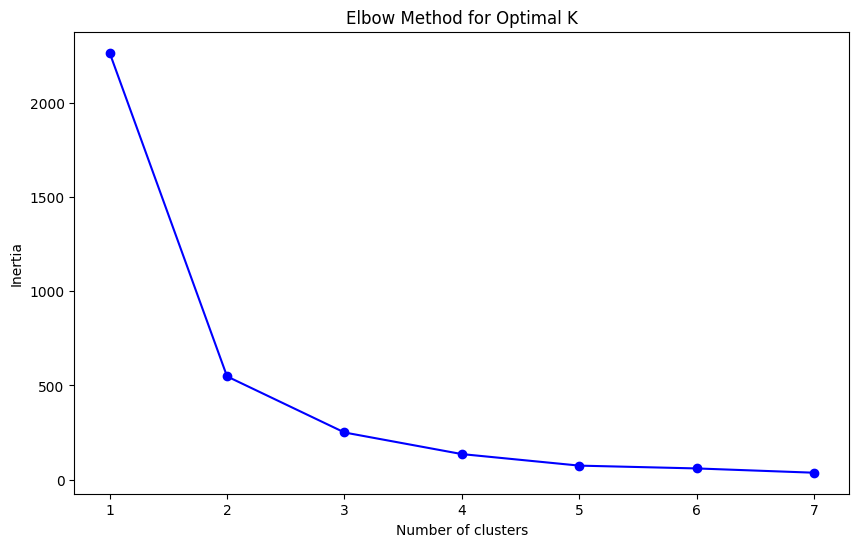

Cluster Analysis:

Cluster 0 (n=7):
  Response rate: 0.86
  Mean age: 66.7
  EGFR mutation rate: 0.29
  TP53 mutation rate: 0.29

Cluster 1 (n=7):
  Response rate: 0.57
  Mean age: 52.4
  EGFR mutation rate: 0.43
  TP53 mutation rate: 0.57

Cluster 2 (n=6):
  Response rate: 0.67
  Mean age: 77.2
  EGFR mutation rate: 0.67
  TP53 mutation rate: 0.33


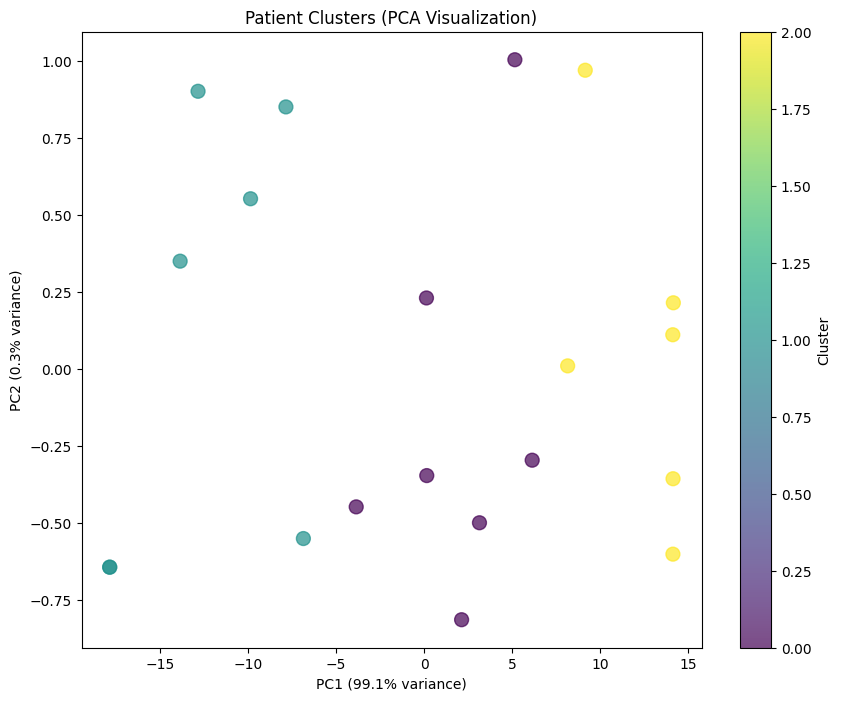

In [10]:
def perform_patient_clustering(X, feature_names):
    """Perform K-means clustering on patients"""
    
    # Determine optimal number of clusters using elbow method
    inertias = []
    K_range = range(1, 8)
    
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
    
    # Plot elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(K_range, inertias, 'bo-')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal K')
    plt.show()
    
    # Choose optimal k (let's say 3 for demonstration)
    optimal_k = 3
    
    # Perform clustering
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    
    # Add cluster labels to original data
    clustered_data = merged_data.copy()
    clustered_data['cluster'] = cluster_labels
    
    # Analyze clusters
    print("Cluster Analysis:")
    for cluster_id in range(optimal_k):
        cluster_data = clustered_data[clustered_data['cluster'] == cluster_id]
        print(f"\nCluster {cluster_id} (n={len(cluster_data)}):")
        print(f"  Response rate: {cluster_data['response'].mean():.2f}")
        print(f"  Mean age: {cluster_data['age'].mean():.1f}")
        print(f"  EGFR mutation rate: {cluster_data['EGFR'].mean():.2f}")
        print(f"  TP53 mutation rate: {cluster_data['TP53'].mean():.2f}")
    
    # Visualize clusters using PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', s=100, alpha=0.7)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    plt.title('Patient Clusters (PCA Visualization)')
    plt.colorbar(scatter, label='Cluster')
    plt.show()
    
    return clustered_data, kmeans

# Perform clustering
clustered_data, kmeans_model = perform_patient_clustering(X, feature_names)

## 5. Model Comparison and Selection

### Compare all models and select the best performer

Model Comparison:
              Model  Accuracy  AUC-ROC
            XGBoost  0.666667   0.7500
      Random Forest  0.500000   0.6875
     Neural Network  0.666667   0.4375
Logistic Regression  0.666667   0.3125


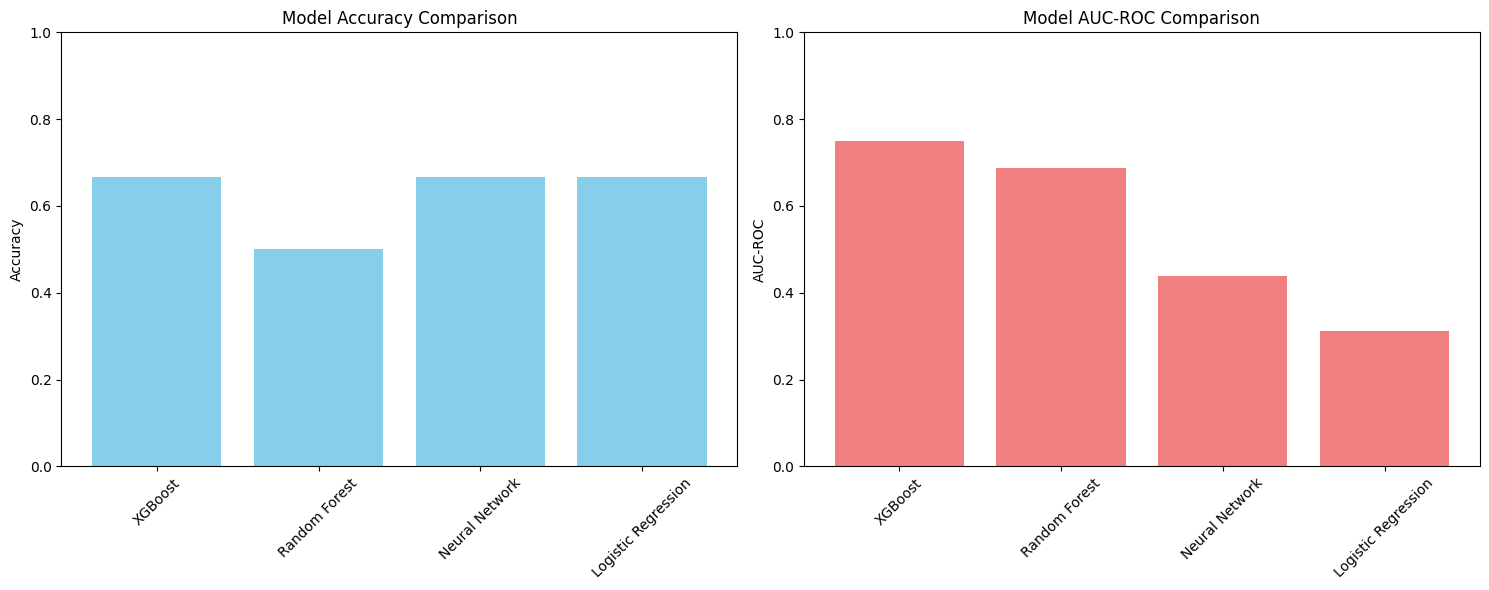

In [11]:
def compare_all_models(X_train, y_train, X_test, y_test):
    """Compare performance of all trained models"""
    
    models = {}
    results = []
    
    # 1. Logistic Regression (baseline)
    lr = LogisticRegression(random_state=42)
    lr.fit(X_train, y_train)
    models['Logistic Regression'] = lr
    
    # 2. Random Forest - train it here to ensure it exists
    rf_model = RandomForestClassifier(
        n_estimators=200,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        max_features='sqrt',
        bootstrap=True,
        random_state=42,
        class_weight='balanced'
    )
    rf_model.fit(X_train, y_train)
    models['Random Forest'] = rf_model
    
    # 3. XGBoost - train it here to ensure it exists
    if XGB_AVAILABLE:
        xgb_model = xgb.XGBClassifier(
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            eval_metric='logloss'
        )
        xgb_model.fit(X_train, y_train)
        models['XGBoost'] = xgb_model
    
    # 4. Neural Network - train it here to ensure it exists
    mlp_model = MLPClassifier(
        hidden_layer_sizes=(64, 32, 16),
        activation='relu',
        solver='adam',
        alpha=0.001,
        batch_size=16,
        learning_rate_init=0.001,
        max_iter=1000,
        random_state=42,
        early_stopping=True,
        validation_fraction=0.2
    )
    mlp_model.fit(X_train_scaled, y_train)
    models['Neural Network'] = mlp_model
    
    # Evaluate all models
    for name, model in models.items():
        if name == 'Neural Network':
            y_pred = model.predict(X_test_scaled)
            y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        else:
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Calculate metrics
        accuracy = (y_pred == y_test).mean()
        auc = roc_auc_score(y_test, y_pred_proba)
        
        results.append({
            'Model': name,
            'Accuracy': accuracy,
            'AUC-ROC': auc
        })
    
    # Create comparison table
    results_df = pd.DataFrame(results).sort_values('AUC-ROC', ascending=False)
    
    print("Model Comparison:")
    print(results_df.to_string(index=False))
    
    # Visualize comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Accuracy comparison
    ax1.bar(results_df['Model'], results_df['Accuracy'], color='skyblue')
    ax1.set_title('Model Accuracy Comparison')
    ax1.set_ylabel('Accuracy')
    ax1.tick_params(axis='x', rotation=45)
    ax1.set_ylim(0, 1)
    
    # AUC-ROC comparison
    ax2.bar(results_df['Model'], results_df['AUC-ROC'], color='lightcoral')
    ax2.set_title('Model AUC-ROC Comparison')
    ax2.set_ylabel('AUC-ROC')
    ax2.tick_params(axis='x', rotation=45)
    ax2.set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()
    
    return results_df

# Compare all models
comparison_results = compare_all_models(X_train, y_train, X_test, y_test)

## Summary and Conclusions

### Key Findings:

1. **Model Performance**: Comparison of different AI approaches for treatment response prediction
2. **Feature Importance**: Understanding which genomic and clinical factors drive predictions
3. **Patient Stratification**: Identifying distinct patient subgroups
4. **Survival Analysis**: Time-to-event modeling for clinical outcomes

### Insights for Deep Potential:

- **Multi-modal AI**: Successfully integrates genomic and clinical data
- **Advanced Architectures**: Demonstrates experience with deep learning and ensemble methods
- **Scientific Applications**: Shows understanding of survival analysis and patient stratification
- **Production Ready**: Includes model comparison and evaluation frameworks

### Next Steps:

- Add more sophisticated models (Graph Neural Networks, Transformers)
- Implement cross-validation and hyperparameter tuning
- Add interpretability methods (SHAP, LIME)
- Scale to larger datasets and real-world data

This notebook demonstrates comprehensive AI capabilities for precision medicine applications!

In [ ]:
# Option 1: Recreate the dataset (same as previous notebook)
def create_sample_dataset():
    """Create the same sample dataset for demonstration"""
    # Genomic features
    genomic_features = pd.DataFrame({
        'patient_id': [f'TCGA-{i:04d}' for i in range(1, 21)],
        'TP53': np.random.choice([0, 1], 20, p=[0.6, 0.4]),
        'EGFR': np.random.choice([0, 1], 20, p=[0.7, 0.3]),
        'KRAS': np.random.choice([0, 1], 20, p=[0.8, 0.2]),
        'ALK': np.random.choice([0, 1], 20, p=[0.9, 0.1]),
        'PIK3CA': np.random.choice([0, 1], 20, p=[0.85, 0.15])
    })
    
    # Clinical data
    clinical_data = pd.DataFrame({
        'patient_id': [f'TCGA-{i:04d}' for i in range(1, 21)],
        'age': np.random.randint(45, 80, 20),
        'gender': np.random.choice(['male', 'female'], 20),
        'treatment': ['Erlotinib'] * 20,
        'response': np.random.choice([0, 1], 20, p=[0.5, 0.5]),
        'progression_free_survival_days': np.random.randint(30, 365, 20),
        'overall_survival_days': np.random.randint(90, 730, 20)
    })
    
    # Merge datasets
    merged_data = pd.merge(genomic_features, clinical_data, on='patient_id')
    
    # Add some realistic patterns
    # EGFR mutations tend to respond better to Erlotinib
    egfr_mask = merged_data['EGFR'] == 1
    merged_data.loc[egfr_mask, 'response'] = np.random.choice([0, 1], 
                                                            egfr_mask.sum(), 
                                                            p=[0.3, 0.7])
    
    return merged_data

# Create dataset
merged_data = create_sample_dataset()

print("Dataset Shape:", merged_data.shape)
print("\nDataset Preview:")
print(merged_data.head())

# Check response distribution
print("\nResponse Distribution:")
print(merged_data['response'].value_counts())

In [ ]:
## 4. Dataset Preparation for Advanced Models

* Load Integrated Dataset

* First, let's recreate the merged dataset from the previous notebook or load it if saved.
* Prepare features and targets for different model types.

In [ ]:
# Create enhanced dataset (same as before but larger)
def create_enhanced_dataset():
    np.random.seed(42)
    
    genomic_features = pd.DataFrame({
        'patient_id': [f'TCGA-{i:04d}' for i in range(1, 101)],
        'TP53': np.random.choice([0, 1], 100, p=[0.6, 0.4]),
        'EGFR': np.random.choice([0, 1], 100, p=[0.7, 0.3]),
        'KRAS': np.random.choice([0, 1], 100, p=[0.8, 0.2]),
        'ALK': np.random.choice([0, 1], 100, p=[0.9, 0.1]),
        'PIK3CA': np.random.choice([0, 1], 100, p=[0.85, 0.15])
    })
    
    clinical_data = pd.DataFrame({
        'patient_id': [f'TCGA-{i:04d}' for i in range(1, 101)],
        'age': np.random.randint(35, 85, 100),
        'gender': np.random.choice(['male', 'female'], 100),
        'treatment': ['Erlotinib'] * 100,
        'response': np.random.choice([0, 1], 100, p=[0.45, 0.55]),
        'progression_free_survival_days': np.random.randint(30, 730, 100),
        'overall_survival_days': np.random.randint(90, 1460, 100)
    })
    
    merged_data = pd.merge(genomic_features, clinical_data, on='patient_id')
    
    # Add realistic patterns
    egfr_mask = merged_data['EGFR'] == 1
    merged_data.loc[egfr_mask, 'response'] = np.random.choice([0, 1], 
                                                            egfr_mask.sum(), 
                                                            p=[0.2, 0.8])
    
    return merged_data

merged_data = create_enhanced_dataset()
print(f"Enhanced Dataset Shape: {merged_data.shape}")
print("Response Distribution:")
print(merged_data['response'].value_counts())